In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from collections import Counter

2025-05-16 13:53:01.666904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 13:53:01.969925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747396382.092127     710 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747396382.127228     710 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747396382.383379     710 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data_dir = '../data/LIS-fingerspelling-dataset'
img_ex = cv2.imread(os.path.join(data_dir, 'a', 'a_ANTONIA_1_bottom.JPG'))
img_ex.shape

(415, 622, 3)

In [3]:
# Automatically creates a dataset form the referred directory. Load the full dataset, shuffle = True ensures randomness
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123
)

# In order to iterare the element we must use the iterative method
data_iterator = dataset.as_numpy_iterator()
data_iterator

Found 6428 files belonging to 22 classes.


I0000 00:00:1747396389.989225     710 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f2cafdfab60>)

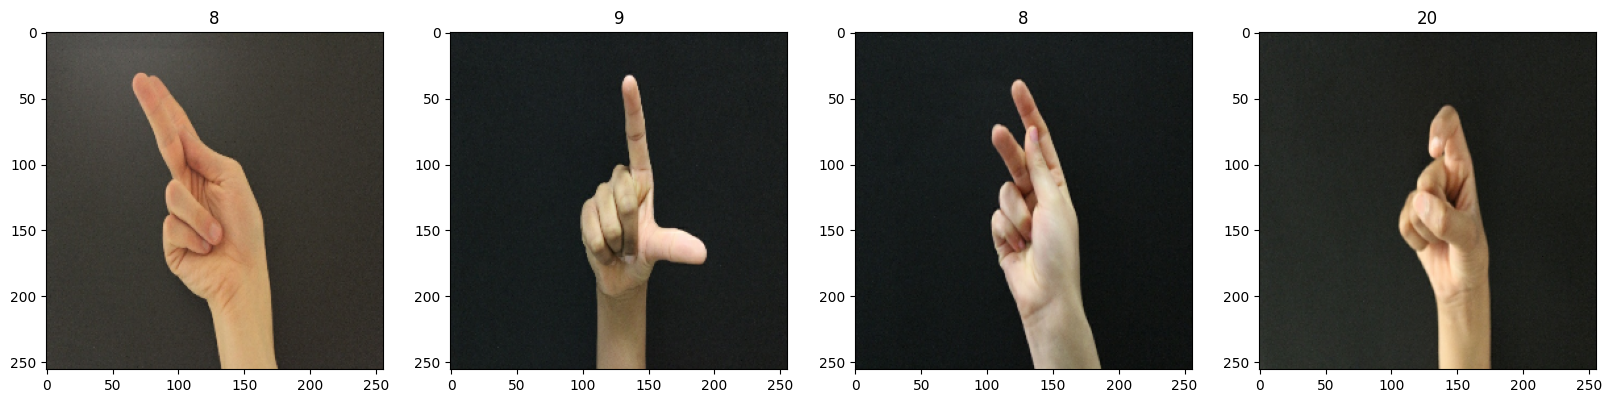

In [4]:
batch = data_iterator.next() # Grabbing a dataset batch

# Exploring a batch labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Data visualization

2025-05-16 13:53:14.775775: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


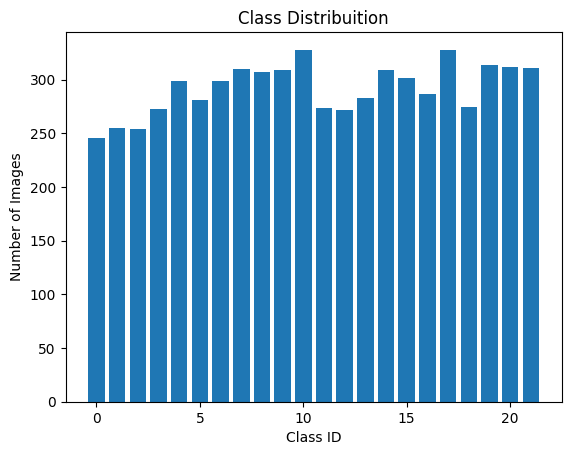

In [5]:
all_labels = []

for _, labels in dataset:
    all_labels.extend(labels.numpy())

label_counts = Counter(all_labels)

# Visualizza distribuzione
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Class Distribuition")
plt.show()

In [6]:
train_dir = '../data/processed/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=123
)

Found 4489 files belonging to 22 classes.


In [7]:
preprocessing_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), 

    # Data augmentation:
    tf.keras.layers.RandomFlip("horizontal"),  # Simulating left hand
    tf.keras.layers.RandomRotation(0.05),       # Rotations, max ±10%

    # Gaussiano noise
    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(
        x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.03), 0.0, 1.0
    )),

    tf.keras.layers.RandomZoom(0.01)
])

train_ds = train_ds.map(lambda x, y: (preprocessing_model(x), y))

In [8]:
train = train_ds.as_numpy_iterator()
batch = train.next()

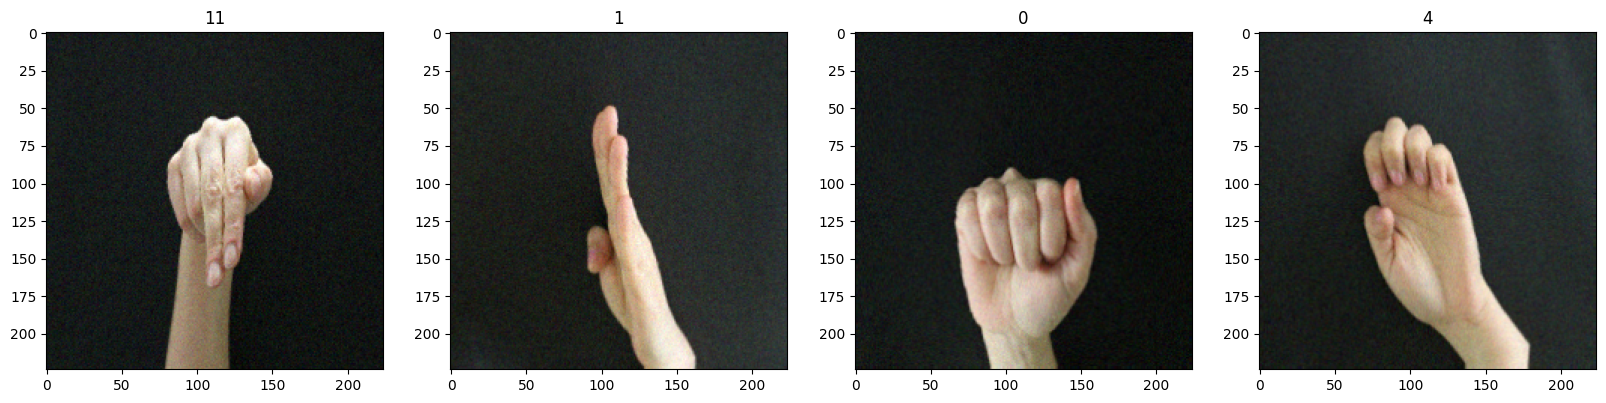

In [9]:
fig, ax = plt.subplots(ncols=4 ,figsize=(20,20))
ax = ax.flatten()

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])